In [1]:
from cnn.model import build_net

from spleen_dataset.dataloader import SpleenDataloader, SpleenDataset, get_training_augmentation, get_validation_augmentation
from spleen_dataset.config import dataset_folder
from spleen_dataset.utils import get_split_deterministic, get_list_of_patients

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import random
import numpy as np

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], False)
  except RuntimeError as e:
    print(e)

2022-10-10 17:40:43.998658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 17:40:44.128212: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 17:40:44.128342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
patients = get_list_of_patients(dataset_folder)

In [3]:
patch_size = (128, 128)
batch_size = 32
num_classes = 2
train_augmentation = get_training_augmentation(patch_size)
val_augmentation = get_validation_augmentation(patch_size)

net_list = [
    'den_d_3', 
    'den_d_3',
    'den_d_3',
    'den_d_3',
    'den_d_3',
    'den_d_3',
    'den_d_3',
    'den_d_3',
    'den_d_3',
]

fn_dict =  {
    'den_d_3': {'cell': 'DownscalingCell', 'block': 'DenseBlock',     'kernel': 3},
    'den_d_5': {'cell': 'DownscalingCell', 'block': 'DenseBlock',     'kernel': 5},
    'den_d_7': {'cell': 'DownscalingCell', 'block': 'DenseBlock',     'kernel': 7},
    'den_n_3': {'cell': 'NonscalingCell',  'block': 'DenseBlock',     'kernel': 3},
    'den_n_5': {'cell': 'NonscalingCell',  'block': 'DenseBlock',     'kernel': 5},
    'den_n_7': {'cell': 'NonscalingCell',  'block': 'DenseBlock',     'kernel': 7},
    'den_u_3': {'cell': 'UpscalingCell',   'block': 'DenseBlock',     'kernel': 3},
    'den_u_5': {'cell': 'UpscalingCell',   'block': 'DenseBlock',     'kernel': 5},
    'den_u_7': {'cell': 'UpscalingCell',   'block': 'DenseBlock',     'kernel': 7},
    'inc_d_3': {'cell': 'DownscalingCell', 'block': 'InceptionBlock', 'kernel': 3},
    'inc_d_5': {'cell': 'DownscalingCell', 'block': 'InceptionBlock', 'kernel': 5},
    'inc_d_7': {'cell': 'DownscalingCell', 'block': 'InceptionBlock', 'kernel': 7},
    'inc_n_3': {'cell': 'NonscalingCell',  'block': 'InceptionBlock', 'kernel': 3},
    'inc_n_5': {'cell': 'NonscalingCell',  'block': 'InceptionBlock', 'kernel': 5},
    'inc_n_7': {'cell': 'NonscalingCell',  'block': 'InceptionBlock', 'kernel': 7},
    'inc_u_3': {'cell': 'UpscalingCell',   'block': 'InceptionBlock', 'kernel': 3},
    'inc_u_5': {'cell': 'UpscalingCell',   'block': 'InceptionBlock', 'kernel': 5},
    'inc_u_7': {'cell': 'UpscalingCell',   'block': 'InceptionBlock', 'kernel': 7},
    'ind_d':   {'cell': 'DownscalingCell', 'block': 'IdentityBlock',             },
    'ind_n':   {'cell': 'NonscalingCell',  'block': 'IdentityBlock',             },   
    'ind_u':   {'cell': 'UpscalingCell',   'block': 'IdentityBlock',             },
    'res_d_3': {'cell': 'DownscalingCell', 'block': 'ResNetBlock',    'kernel': 3},
    'res_d_5': {'cell': 'DownscalingCell', 'block': 'ResNetBlock',    'kernel': 5},
    'res_d_7': {'cell': 'DownscalingCell', 'block': 'ResNetBlock',    'kernel': 7},
    'res_n_3': {'cell': 'NonscalingCell',  'block': 'ResNetBlock',    'kernel': 3},
    'res_n_5': {'cell': 'NonscalingCell',  'block': 'ResNetBlock',    'kernel': 5},
    'res_n_7': {'cell': 'NonscalingCell',  'block': 'ResNetBlock',    'kernel': 7},
    'res_u_3': {'cell': 'UpscalingCell',   'block': 'ResNetBlock',    'kernel': 3},
    'res_u_5': {'cell': 'UpscalingCell',   'block': 'ResNetBlock',    'kernel': 5},
    'res_u_7': {'cell': 'UpscalingCell',   'block': 'ResNetBlock',    'kernel': 7},
    'vgg_d_3': {'cell': 'DownscalingCell', 'block': 'VGGBlock',       'kernel': 3},
    'vgg_d_5': {'cell': 'DownscalingCell', 'block': 'VGGBlock',       'kernel': 5},
    'vgg_d_7': {'cell': 'DownscalingCell', 'block': 'VGGBlock',       'kernel': 7},
    'vgg_n_3': {'cell': 'NonscalingCell',  'block': 'VGGBlock',       'kernel': 3},
    'vgg_n_5': {'cell': 'NonscalingCell',  'block': 'VGGBlock',       'kernel': 5},
    'vgg_n_7': {'cell': 'NonscalingCell',  'block': 'VGGBlock',       'kernel': 7},
    'vgg_u_3': {'cell': 'UpscalingCell',   'block': 'VGGBlock',       'kernel': 3},
    'vgg_u_5': {'cell': 'UpscalingCell',   'block': 'VGGBlock',       'kernel': 5},
    'vgg_u_7': {'cell': 'UpscalingCell',   'block': 'VGGBlock',       'kernel': 7},
}

/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


2022-10-10 17:41:22.546109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-10 17:41:22.548313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 17:41:22.548538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 17:41:22.548633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Epoch 1/50


2022-10-10 17:41:30.076511: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.
2022-10-10 17:41:30.090870: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23592960 exceeds 10% of free system memory.
2022-10-10 17:41:30.103542: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 23592960 exceeds 10% of free system memory.
2022-10-10 17:41:30.113226: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.
2022-10-10 17:41:30.194163: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 18874368 exceeds 10% of free system memory.
2022-10-10 17:41:32.729529: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-10-10 17:41:35.220471: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


26/26 [==============================] - 26s 409ms/step - loss: 0.9812 - gen_dice_coef: 0.0413 - soft_gen_dice_coef: 0.0419 - val_loss: 0.9832 - val_gen_dice_coef: 0.0432 - val_soft_gen_dice_coef: 0.0393 - lr: 0.0010
Epoch 2/50
26/26 [==============================] - 9s 356ms/step - loss: 0.9677 - gen_dice_coef: 0.0634 - soft_gen_dice_coef: 0.0540 - val_loss: 0.9735 - val_gen_dice_coef: 0.0641 - val_soft_gen_dice_coef: 0.0473 - lr: 9.8378e-04
Epoch 3/50
26/26 [==============================] - 9s 357ms/step - loss: 0.9544 - gen_dice_coef: 0.0866 - soft_gen_dice_coef: 0.0654 - val_loss: 0.9601 - val_gen_dice_coef: 0.0805 - val_soft_gen_dice_coef: 0.0587 - lr: 9.6753e-04
Epoch 4/50
26/26 [==============================] - 9s 362ms/step - loss: 0.9356 - gen_dice_coef: 0.1110 - soft_gen_dice_coef: 0.0825 - val_loss: 0.9409 - val_gen_dice_coef: 0.1093 - val_soft_gen_dice_coef: 0.0764 - lr: 9.5125e-04
Epoch 5/50
26/26 [==============================] - 9s 362ms/step - loss: 0.9050 - gen_dic

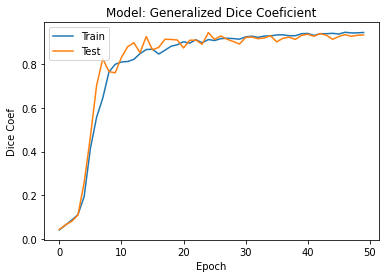

Epoch 1/50
26/26 [==============================] - 16s 417ms/step - loss: 0.9562 - gen_dice_coef: 0.1080 - soft_gen_dice_coef: 0.0673 - val_loss: 0.9299 - val_gen_dice_coef: 0.1518 - val_soft_gen_dice_coef: 0.0935 - lr: 0.0010
Epoch 2/50
26/26 [==============================] - 9s 361ms/step - loss: 0.9257 - gen_dice_coef: 0.2026 - soft_gen_dice_coef: 0.0973 - val_loss: 0.8904 - val_gen_dice_coef: 0.3407 - val_soft_gen_dice_coef: 0.1322 - lr: 9.8378e-04
Epoch 3/50
26/26 [==============================] - 10s 367ms/step - loss: 0.8825 - gen_dice_coef: 0.3751 - soft_gen_dice_coef: 0.1398 - val_loss: 0.8291 - val_gen_dice_coef: 0.5222 - val_soft_gen_dice_coef: 0.1931 - lr: 9.6753e-04
Epoch 4/50
26/26 [==============================] - 10s 368ms/step - loss: 0.8148 - gen_dice_coef: 0.5119 - soft_gen_dice_coef: 0.2072 - val_loss: 0.7314 - val_gen_dice_coef: 0.6397 - val_soft_gen_dice_coef: 0.2904 - lr: 9.5125e-04
Epoch 5/50
26/26 [==============================] - 10s 367ms/step - loss: 0.

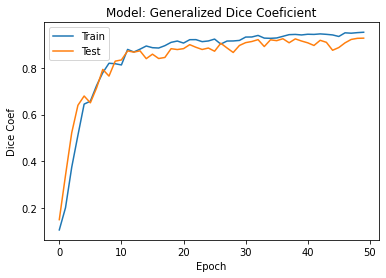

Epoch 1/50
28/28 [==============================] - 15s 364ms/step - loss: 0.9348 - gen_dice_coef: 0.1276 - soft_gen_dice_coef: 0.0888 - val_loss: 0.9079 - val_gen_dice_coef: 0.1670 - val_soft_gen_dice_coef: 0.1155 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 9s 316ms/step - loss: 0.8515 - gen_dice_coef: 0.3058 - soft_gen_dice_coef: 0.1717 - val_loss: 0.8387 - val_gen_dice_coef: 0.3066 - val_soft_gen_dice_coef: 0.1846 - lr: 9.8378e-04
Epoch 3/50
28/28 [==============================] - 9s 321ms/step - loss: 0.7602 - gen_dice_coef: 0.4514 - soft_gen_dice_coef: 0.2632 - val_loss: 0.6524 - val_gen_dice_coef: 0.6913 - val_soft_gen_dice_coef: 0.3711 - lr: 9.6753e-04
Epoch 4/50
28/28 [==============================] - 9s 323ms/step - loss: 0.5812 - gen_dice_coef: 0.6848 - soft_gen_dice_coef: 0.4421 - val_loss: 0.5195 - val_gen_dice_coef: 0.6781 - val_soft_gen_dice_coef: 0.5038 - lr: 9.5125e-04
Epoch 5/50
28/28 [==============================] - 9s 323ms/step - loss: 0.454

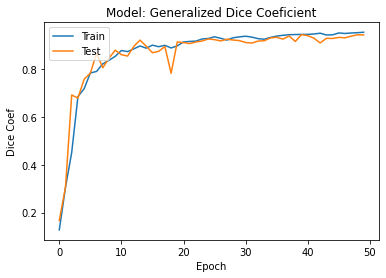

Epoch 1/50
25/25 [==============================] - 17s 461ms/step - loss: 0.9445 - gen_dice_coef: 0.1210 - soft_gen_dice_coef: 0.0791 - val_loss: 0.9002 - val_gen_dice_coef: 0.1999 - val_soft_gen_dice_coef: 0.1233 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 9s 354ms/step - loss: 0.8805 - gen_dice_coef: 0.2860 - soft_gen_dice_coef: 0.1428 - val_loss: 0.8102 - val_gen_dice_coef: 0.4424 - val_soft_gen_dice_coef: 0.2131 - lr: 9.8378e-04
Epoch 3/50
25/25 [==============================] - 9s 360ms/step - loss: 0.7829 - gen_dice_coef: 0.5137 - soft_gen_dice_coef: 0.2404 - val_loss: 0.6770 - val_gen_dice_coef: 0.6926 - val_soft_gen_dice_coef: 0.3464 - lr: 9.6753e-04
Epoch 4/50
25/25 [==============================] - 9s 362ms/step - loss: 0.6683 - gen_dice_coef: 0.6295 - soft_gen_dice_coef: 0.3551 - val_loss: 0.6117 - val_gen_dice_coef: 0.5915 - val_soft_gen_dice_coef: 0.4118 - lr: 9.5125e-04
Epoch 5/50
25/25 [==============================] - 9s 359ms/step - loss: 0.540

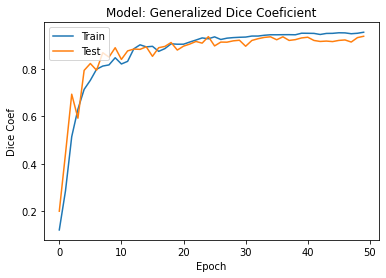

Epoch 1/50
25/25 [==============================] - 17s 441ms/step - loss: 0.9313 - gen_dice_coef: 0.1802 - soft_gen_dice_coef: 0.0922 - val_loss: 0.8858 - val_gen_dice_coef: 0.4274 - val_soft_gen_dice_coef: 0.1377 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 9s 372ms/step - loss: 0.8466 - gen_dice_coef: 0.4330 - soft_gen_dice_coef: 0.1768 - val_loss: 0.8159 - val_gen_dice_coef: 0.5819 - val_soft_gen_dice_coef: 0.2074 - lr: 9.8378e-04
Epoch 3/50
25/25 [==============================] - 9s 377ms/step - loss: 0.7955 - gen_dice_coef: 0.4822 - soft_gen_dice_coef: 0.2279 - val_loss: 0.7666 - val_gen_dice_coef: 0.5958 - val_soft_gen_dice_coef: 0.2567 - lr: 9.6753e-04
Epoch 4/50
25/25 [==============================] - 9s 368ms/step - loss: 0.6828 - gen_dice_coef: 0.6609 - soft_gen_dice_coef: 0.3405 - val_loss: 0.6196 - val_gen_dice_coef: 0.7230 - val_soft_gen_dice_coef: 0.4037 - lr: 9.5125e-04
Epoch 5/50
25/25 [==============================] - 9s 367ms/step - loss: 0.553

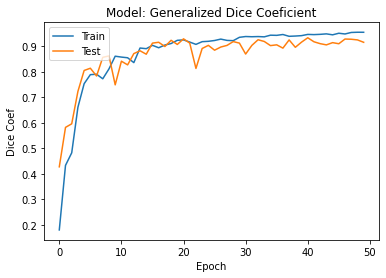

Epoch 1/50
25/25 [==============================] - 15s 382ms/step - loss: 0.9307 - gen_dice_coef: 0.1464 - soft_gen_dice_coef: 0.0929 - val_loss: 0.8758 - val_gen_dice_coef: 0.2456 - val_soft_gen_dice_coef: 0.1478 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 8s 329ms/step - loss: 0.8407 - gen_dice_coef: 0.4000 - soft_gen_dice_coef: 0.1828 - val_loss: 0.8135 - val_gen_dice_coef: 0.5284 - val_soft_gen_dice_coef: 0.2101 - lr: 9.8378e-04
Epoch 3/50
25/25 [==============================] - 8s 333ms/step - loss: 0.7622 - gen_dice_coef: 0.5496 - soft_gen_dice_coef: 0.2615 - val_loss: 0.6778 - val_gen_dice_coef: 0.6532 - val_soft_gen_dice_coef: 0.3460 - lr: 9.6753e-04
Epoch 4/50
25/25 [==============================] - 8s 337ms/step - loss: 0.6653 - gen_dice_coef: 0.6579 - soft_gen_dice_coef: 0.3585 - val_loss: 0.5857 - val_gen_dice_coef: 0.7324 - val_soft_gen_dice_coef: 0.4381 - lr: 9.5125e-04
Epoch 5/50
25/25 [==============================] - 9s 338ms/step - loss: 0.564

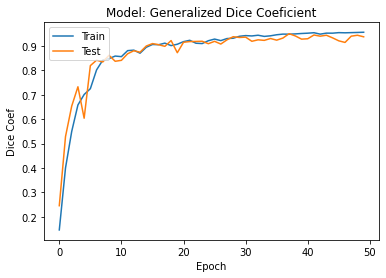

Epoch 1/50
28/28 [==============================] - 15s 355ms/step - loss: 0.8735 - gen_dice_coef: 0.2487 - soft_gen_dice_coef: 0.1503 - val_loss: 0.7403 - val_gen_dice_coef: 0.5612 - val_soft_gen_dice_coef: 0.2837 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 9s 315ms/step - loss: 0.6718 - gen_dice_coef: 0.6321 - soft_gen_dice_coef: 0.3523 - val_loss: 0.5831 - val_gen_dice_coef: 0.7669 - val_soft_gen_dice_coef: 0.4411 - lr: 9.8378e-04
Epoch 3/50
28/28 [==============================] - 9s 322ms/step - loss: 0.5752 - gen_dice_coef: 0.6811 - soft_gen_dice_coef: 0.4491 - val_loss: 0.5606 - val_gen_dice_coef: 0.6557 - val_soft_gen_dice_coef: 0.4638 - lr: 9.6753e-04
Epoch 4/50
28/28 [==============================] - 9s 323ms/step - loss: 0.4824 - gen_dice_coef: 0.7223 - soft_gen_dice_coef: 0.5421 - val_loss: 0.3556 - val_gen_dice_coef: 0.8489 - val_soft_gen_dice_coef: 0.6690 - lr: 9.5125e-04
Epoch 5/50
28/28 [==============================] - 9s 323ms/step - loss: 0.408

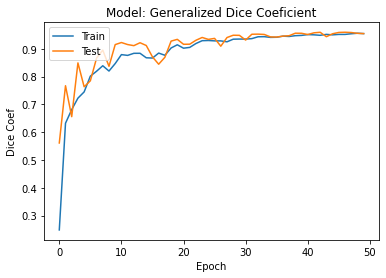

Epoch 1/50
28/28 [==============================] - 17s 415ms/step - loss: 0.8554 - gen_dice_coef: 0.2486 - soft_gen_dice_coef: 0.1683 - val_loss: 0.7623 - val_gen_dice_coef: 0.3888 - val_soft_gen_dice_coef: 0.2615 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 10s 351ms/step - loss: 0.6399 - gen_dice_coef: 0.5475 - soft_gen_dice_coef: 0.3841 - val_loss: 0.6133 - val_gen_dice_coef: 0.5656 - val_soft_gen_dice_coef: 0.4109 - lr: 9.8378e-04
Epoch 3/50
28/28 [==============================] - 10s 352ms/step - loss: 0.5106 - gen_dice_coef: 0.6558 - soft_gen_dice_coef: 0.5137 - val_loss: 0.5774 - val_gen_dice_coef: 0.5470 - val_soft_gen_dice_coef: 0.4471 - lr: 9.6753e-04
Epoch 4/50
28/28 [==============================] - 10s 356ms/step - loss: 0.4138 - gen_dice_coef: 0.7184 - soft_gen_dice_coef: 0.6110 - val_loss: 0.3959 - val_gen_dice_coef: 0.7139 - val_soft_gen_dice_coef: 0.6289 - lr: 9.5125e-04
Epoch 5/50
28/28 [==============================] - 10s 351ms/step - loss: 0

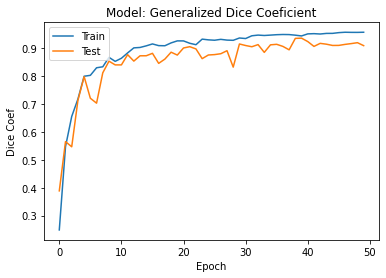

Epoch 1/50
25/25 [==============================] - 15s 388ms/step - loss: 0.9620 - gen_dice_coef: 0.0922 - soft_gen_dice_coef: 0.0614 - val_loss: 0.9226 - val_gen_dice_coef: 0.1844 - val_soft_gen_dice_coef: 0.1006 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 8s 328ms/step - loss: 0.9180 - gen_dice_coef: 0.2367 - soft_gen_dice_coef: 0.1049 - val_loss: 0.8649 - val_gen_dice_coef: 0.3869 - val_soft_gen_dice_coef: 0.1578 - lr: 9.8378e-04
Epoch 3/50
25/25 [==============================] - 8s 336ms/step - loss: 0.8639 - gen_dice_coef: 0.4219 - soft_gen_dice_coef: 0.1587 - val_loss: 0.8023 - val_gen_dice_coef: 0.4982 - val_soft_gen_dice_coef: 0.2202 - lr: 9.6753e-04
Epoch 4/50
25/25 [==============================] - 9s 338ms/step - loss: 0.7952 - gen_dice_coef: 0.4961 - soft_gen_dice_coef: 0.2272 - val_loss: 0.6651 - val_gen_dice_coef: 0.8017 - val_soft_gen_dice_coef: 0.3571 - lr: 9.5125e-04
Epoch 5/50
25/25 [==============================] - 8s 337ms/step - loss: 0.668

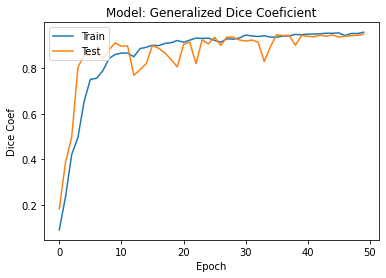

Epoch 1/50
24/24 [==============================] - 16s 412ms/step - loss: 0.9697 - gen_dice_coef: 0.0692 - soft_gen_dice_coef: 0.0538 - val_loss: 0.9691 - val_gen_dice_coef: 0.0831 - val_soft_gen_dice_coef: 0.0541 - lr: 0.0010
Epoch 2/50
24/24 [==============================] - 8s 333ms/step - loss: 0.9502 - gen_dice_coef: 0.0997 - soft_gen_dice_coef: 0.0725 - val_loss: 0.9579 - val_gen_dice_coef: 0.0952 - val_soft_gen_dice_coef: 0.0642 - lr: 9.8378e-04
Epoch 3/50
24/24 [==============================] - 8s 341ms/step - loss: 0.9298 - gen_dice_coef: 0.1640 - soft_gen_dice_coef: 0.0917 - val_loss: 0.9353 - val_gen_dice_coef: 0.2706 - val_soft_gen_dice_coef: 0.0856 - lr: 9.6753e-04
Epoch 4/50
24/24 [==============================] - 8s 340ms/step - loss: 0.9039 - gen_dice_coef: 0.2709 - soft_gen_dice_coef: 0.1167 - val_loss: 0.8954 - val_gen_dice_coef: 0.3515 - val_soft_gen_dice_coef: 0.1248 - lr: 9.5125e-04
Epoch 5/50
24/24 [==============================] - 8s 339ms/step - loss: 0.840

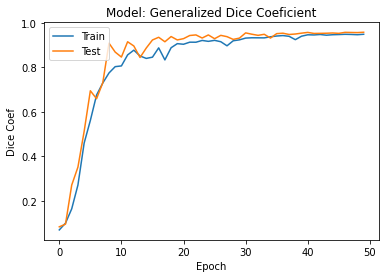

Epoch 1/50
25/25 [==============================] - 17s 442ms/step - loss: 0.9360 - gen_dice_coef: 0.1499 - soft_gen_dice_coef: 0.0877 - val_loss: 0.8998 - val_gen_dice_coef: 0.2784 - val_soft_gen_dice_coef: 0.1238 - lr: 0.0010
Epoch 2/50
25/25 [==============================] - 9s 371ms/step - loss: 0.8744 - gen_dice_coef: 0.3444 - soft_gen_dice_coef: 0.1491 - val_loss: 0.8387 - val_gen_dice_coef: 0.4353 - val_soft_gen_dice_coef: 0.1847 - lr: 9.8378e-04
Epoch 3/50
25/25 [==============================] - 10s 378ms/step - loss: 0.8074 - gen_dice_coef: 0.5200 - soft_gen_dice_coef: 0.2160 - val_loss: 0.7507 - val_gen_dice_coef: 0.7163 - val_soft_gen_dice_coef: 0.2727 - lr: 9.6753e-04
Epoch 4/50
25/25 [==============================] - 9s 377ms/step - loss: 0.7359 - gen_dice_coef: 0.6134 - soft_gen_dice_coef: 0.2875 - val_loss: 0.6993 - val_gen_dice_coef: 0.6728 - val_soft_gen_dice_coef: 0.3241 - lr: 9.5125e-04
Epoch 5/50
25/25 [==============================] - 10s 380ms/step - loss: 0.6

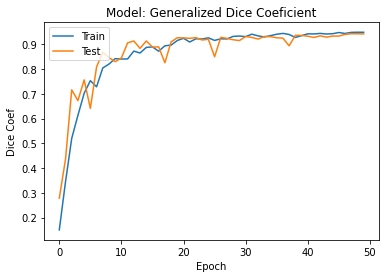

In [4]:
val_gen_dice_coef_list = []
num_splits = 5
num_initializations = 3
epochs = 50
evaluation_epochs = int(0.2 * epochs)

for initialization in range(num_initializations):

    for fold in range(num_splits):
        train_patients, val_patients = get_split_deterministic(patients, fold=fold, num_splits=num_splits, random_state=initialization)

        train_dataset = SpleenDataset(train_patients, only_non_empty_slices=True)
        val_dataset = SpleenDataset(val_patients, only_non_empty_slices=True)

        train_dataloader = SpleenDataloader(train_dataset, batch_size, train_augmentation)
        val_dataloader = SpleenDataloader(val_dataset, batch_size, val_augmentation)

        model = build_net((*patch_size, 1), num_classes, fn_dict, net_list)
 
        def learning_rate_fn(epoch):
            initial_learning_rate = 1e-3
            end_learning_rate = 1e-4
            power = 0.9
            return ((initial_learning_rate - end_learning_rate) *
                (1 - epoch / float(epochs)) ** (power)
                ) + end_learning_rate
            
        lr_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_fn, verbose=False)

        history = model.fit(
            train_dataloader,
            validation_data=val_dataloader,
            epochs=epochs,
            verbose=0,
            callbacks=[
                lr_callback
            ]
        )
        
        print(history.history['val_gen_dice_coef'][-evaluation_epochs:])

        val_gen_dice_coef_list.extend(history.history['val_gen_dice_coef'][-evaluation_epochs:])

        # for patient in val_patients:
        #     patient_dataset = SpleenDataset([patient], only_non_empty_slices=True)
        #     patient_dataloader = SpleenDataloader(patient_dataset, 1, val_augmentation, shuffle=False)
        #     results = model.evaluate(patient_dataloader)
        #     val_gen_dice_coef_patient = results[-1]
        #     val_gen_dice_coef_list.append(val_gen_dice_coef_patient)

        #plotting the dice coef results (accuracy) as a function of the number of epochs
        plt.figure()
        plt.plot(history.history['gen_dice_coef'])
        plt.plot(history.history['val_gen_dice_coef'])
        plt.title('Model: Generalized Dice Coeficient')
        plt.ylabel('Dice Coef')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        #plotting the dice coef results (loss function) as a function of the number of epochs
        # plt.figure()
        # plt.plot(history.history['loss'])
        # plt.plot(history.history['val_loss'])
        # plt.title('Model: Generalized Dice Coeficient')
        # plt.ylabel('Dice Loss')
        # plt.xlabel('Epoch')
        # plt.legend(['Train', 'Test'], loc='upper right')
        # plt.show()

mean_val_gen_dice_coef = (np.mean(val_gen_dice_coef_list))
std_val_gen_dice_coef = (np.std(val_gen_dice_coef_list))

print(f'Dice {mean_val_gen_dice_coef} +- {std_val_gen_dice_coef}')

In [ ]:
#!tensorboard --logdir='./logs'